In [44]:
import os
import numpy as np
from matplotlib import pyplot as plt      
import pandas as pd
from scipy import special                 
import array
import scipy as sp
import scipy.interpolate
import re
def unPackRawFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    return distance, pec_vel, temp, HI_density
def unPackDenFile(raw_path):
    """
    - unpacks the .raw file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    neutral_fraction = y[:,1]
    gas_density  = y[:,2]
    temperature = y[:,3]
   
    return distance, neutral_fraction,gas_density,temperature
def calculate_gamma(temperature,density,xHI,scale):
    '''Gamma = R(T)*ne/xHI, R(T) = 4.3e-13 * (T/1e4K)^{-0.7), ne = 0.82*nb.
    '''
    omega_b = 0.0479; h = 0.6814
    mean_nb = 1.123e-5/scale**3*omega_b*h**2
    nb = np.multiply(density ,mean_nb); ne = 0.82*nb
    R_T = 4.3e-13 * (np.divide(temperature,1e4))**(-0.7)
    gamma = R_T * ne / xHI
    return gamma

In [45]:
sigma = 6.3e-18

In [46]:
# neutral fraction is defined with the old peak finder, the new finder neutral fraction is different. want to look at why the low ones are weird.
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    count = 0
    neutral_fraction_limit = 1e-3
    lyman_limited_value = []
    fraction = []
    gas_density_normalized =[]
    HI = []
    checkout = []
    base_difference = []
    for i in range(1000):
        den_path =  'los.00' + '{0:03}'.format(i) +'.den'
        distance,neutral_fraction,gas_density,temperature = unPackDenFile(den_path)
        distance_cm = distance *0.1453*3.086e24 /0.68
        for k in range(len(distance) -2):
            if(neutral_fraction[k]<neutral_fraction_limit and neutral_fraction[k+1]>neutral_fraction_limit):
                left_bases = k+1
                peak_fraction = neutral_fraction[k]
                peak_HI = neutral_fraction[k]*gas_density[k]
                peak_distance = distance[k]
                peak_density = gas_density[k]
                if( k+1 <len(distance)):
                    while(not(neutral_fraction[k]>neutral_fraction_limit and neutral_fraction[k+1]<neutral_fraction_limit) and k <len(distance)-2):
                        right_bases = k+1
                        k+=1
                        if(neutral_fraction[k]>peak_fraction):
                            peak_fraction = neutral_fraction[k]
                            peak_HI = neutral_fraction[k]*gas_density[k]
                            peak_distance = distance[k]
                            peak_density = gas_density[k]
                    area_under = peak_HI *1/2*(distance_cm[right_bases]-distance_cm[left_bases])/0.937415
                    if(area_under >= (10**15)and area_under  <= (10**22)and distance[right_bases] - distance[left_bases] <9.765e-3):
                        checkout.append([i,peak_distance,distance[left_bases], distance[right_bases], area_under*sigma, peak_fraction])
                    if(area_under >= (10**15)and area_under  <= (10**22)):
                        lyman_limited_value.append(area_under)
                        fraction.append(peak_fraction)
                        gas_density_normalized.append(peak_density)
                        HI.append(peak_HI)
                        base_difference.append(distance[right_bases] - distance[left_bases])
    return lyman_limited_value,fraction,gas_density_normalized,HI,base_difference
lyman_limited_value,neutral_fraction,gas_density_normalized,HI,base_difference= lyman_identification()


In [89]:
lyman_limited_value

[3.3037484033828064e+16,
 5524222362910470.0,
 2.631573551473985e+16,
 1.6894112612721662e+20,
 2.4004761994620868e+16,
 1.600742664261836e+16,
 8.264353133498088e+19,
 5.772948167895585e+19,
 6.506044880654372e+18,
 1.3807799219774194e+16,
 8134691038206838.0,
 8927985304429868.0,
 1.2652670839594574e+16,
 8975079109439684.0,
 1.4539662777011342e+16,
 1.1577723463655045e+19,
 4854423900302952.0,
 2.988998299570215e+19,
 7.424680435333638e+16,
 4.248281450733806e+17,
 1.2113423215767158e+17,
 1.132363452625757e+19,
 2.7133450195498364e+16,
 8.860971424374275e+18,
 2.020767808789106e+17,
 2.00011421451246e+20,
 4256899546694352.5,
 1.615682178906216e+16,
 2.7657615867868074e+19,
 2.1637295420211336e+16,
 2.741570458567618e+16,
 1.7295051824375132e+16,
 2.2539070348604396e+16,
 1.754113715945139e+19,
 2.03524955246034e+20,
 1.1913765513113933e+18,
 1.2823228895036727e+20,
 1.2209024259514744e+18,
 1.5910582389502714e+17,
 1.47850307678045e+19,
 4.309280715799506e+17,
 6047807518987077.0,

Text(0.5, 1.0, 'number counts vs gas number density')

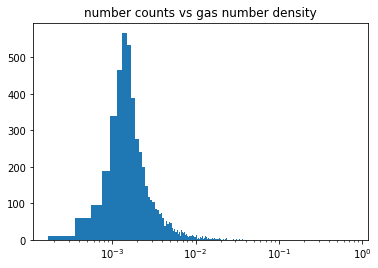

In [47]:
plt.hist(gas_density_normalized,bins =4000)
plt.xscale("log")
plt.title("number counts vs gas number density")

In [48]:
optical_depth = np.multiply(sigma,lyman_limited_value)

Text(0, 0.5, 'opticel depth')

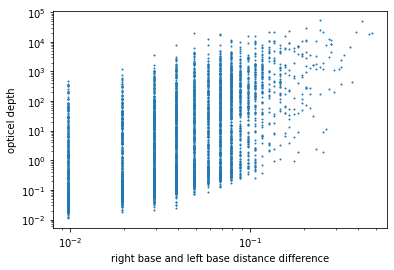

In [49]:
plt.scatter(base_difference,optical_depth,s =1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("right base and left base distance difference")
plt.ylabel("opticel depth")

Text(0, 0.5, 'opticel depth')

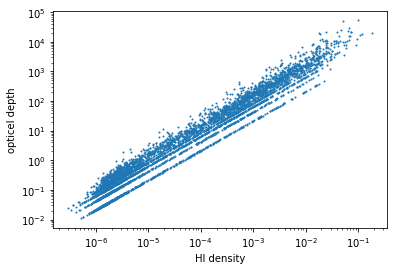

In [50]:
plt.scatter(HI,optical_depth,s =1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("HI density")
plt.ylabel("opticel depth")

In [74]:
rho = 1.674e-24 *1e-3

In [64]:
optical_depth = np.multiply(sigma,lyman_limited_value)

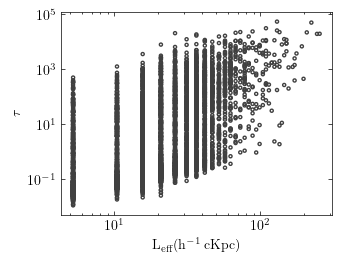

In [65]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("$\mathrm{L_{eff}(h^{-1}\:cKpc)}$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(np.multiply(np.divide(lyman_limited_value,HI),3.24078e-22/0.1453*0.68),optical_depth,s = 5,facecolors='none', edgecolors="0.25")
    plt.savefig('f4_uniform_40_L_eff.pdf') 

In [66]:
L_eff = np.multiply(np.divide(lyman_limited_value,HI),3.24078e-22/0.1453*0.68)
L_eff_checkout = []
for i in L_eff:
    if(i<10):
        L_eff_checkout.append(i)
L_eff_checkout

[5.211684791239284,
 5.21168479123581,
 5.206350415811085,
 5.206350415824982,
 5.211684791239284,
 5.211684791246234,
 5.206350415813691,
 5.211684791239719,
 5.211684791239284,
 5.206350415811084,
 5.206350415818034,
 5.211684791239285,
 5.206350415824983,
 5.206350415818034,
 5.206350415811085,
 5.211684791239284,
 5.206350415811084,
 5.211684791238416,
 5.211684791239285,
 5.211684791239285,
 5.211684791246234,
 5.211684791246233,
 5.211684791242758,
 5.206350415814558,
 5.206350415812821,
 5.211684791242759,
 5.211684791239284,
 5.211684791242759,
 5.206350415811084,
 5.211684791239284,
 5.206350415814559,
 5.211684791235811,
 5.206350415811084,
 5.206350415812821,
 5.206350415824983,
 5.211684791239284,
 5.211684791239285,
 5.211684791242759,
 5.206350415824983,
 5.211684791246233,
 5.211684791241022,
 5.2116847912375475,
 5.211684791242759,
 5.211684791239284,
 5.211684791246234,
 5.206350415811084,
 5.211684791232335,
 5.211684791246233,
 5.206350415813691,
 5.206350415812822,


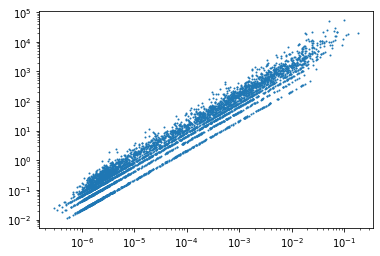

In [67]:
plt.scatter(HI,optical_depth,s =1)
plt.xscale("log")
plt.yscale("log")

In [68]:
issues = []
for i in range(len(optical_depth)):
    issues.append([optical_depth[i],HI[i]])

In [87]:
value = np.multiply(gas_density_normalized,1.674e-24)/7.181677211452862e-28

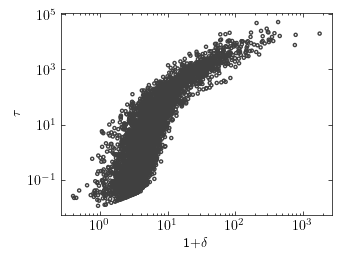

In [88]:
import matplotlib.pyplot as plt
with plt.style.context('science','notebook'):
    plt.xlabel("1+$\delta$",fontsize = 10)
    plt.ylabel(r"$\tau$",fontsize = 10)
    plt.xscale("log")
    plt.yscale("log")
    plt.scatter(value,optical_depth,s = 5,facecolors='none', edgecolors="0.25")
    plt.savefig('f4_uniform_40_1+delta.pdf') 

In [ ]:
def lyman_graph(lyman_limited_value):
    lyman_limited_value_sorted = sorted(lyman_limited_value)
    min_value_lyman_limited_value = np.log10(min(lyman_limited_value_sorted))
    max_value_lyman_limited_value = np.log10(max(lyman_limited_value_sorted))
    print(min_value_lyman_limited_value)
    print(max_value_lyman_limited_value)
    bins = np.linspace(min_value_lyman_limited_value,max_value_lyman_limited_value,51)
    ##divide up the data 
    bin_data = pd.DataFrame()
    bin_data['cut_lyman_limited'] = np.array(lyman_limited_value_sorted)
    bin_data['cut_lyman_limited'] = pd.cut(np.log10(bin_data['cut_lyman_limited']), bins = bins,include_lowest = True).astype(str)
    from matplotlib.pyplot import figure
    fig, ax = plt.subplots()
    hist = ax.hist(bin_data,bins=50,cumulative =1,log =True)
    plt.show()
    number_count = []
    for i in range(1, len(hist[0])):
        number_count.append(hist[0][i]- hist[0][i-1])
    total =0 
    for i in number_count:
        total += i
    d_N_column= []
    for i in range(1,50):
        d_N_column.append(10**bins[i]-10**bins[i-1])
    aH = 145.0576616872343
    y_value = []
    #dz = dv/c = H*dr/c = H*a*dx/c
    #dx = 200cMpc * number of line of sights
    dz = aH*(100*1000)/(3e5) 
    for i,k in zip(number_count,d_N_column):
        y_value.append(i/(dz*(k)))
    x_value = []
    for i in range(1,50):
        x_value.append(bins[i])
    plt.plot(x_value,y_value)
    plt.yscale('log')
    plt.show()

15.248660248937194
21.9236526152092


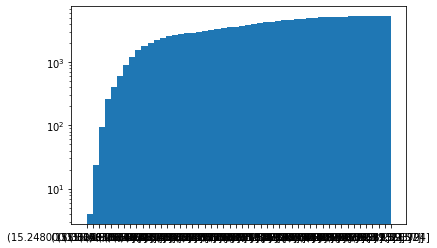

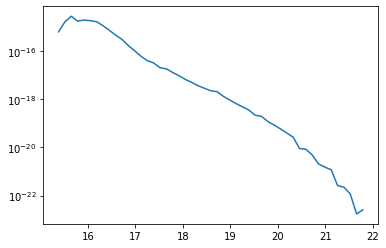

In [ ]:
lyman_graph(lyman_limited_value)

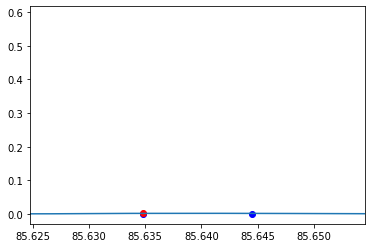

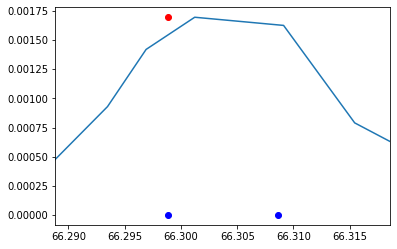

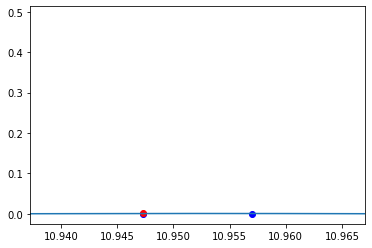

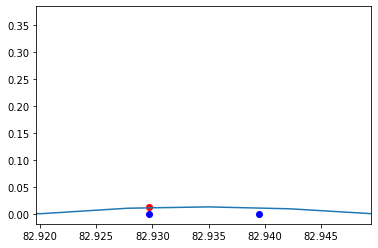

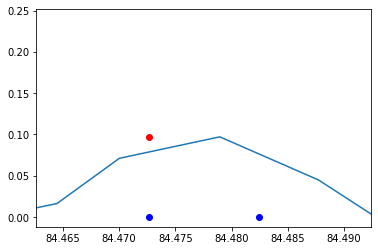

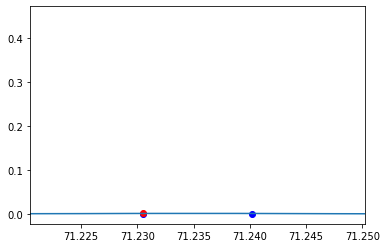

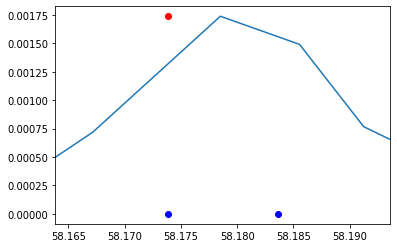

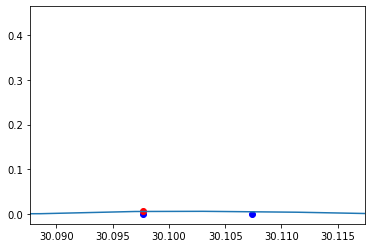

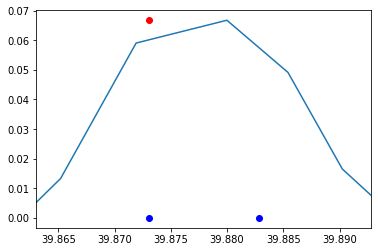

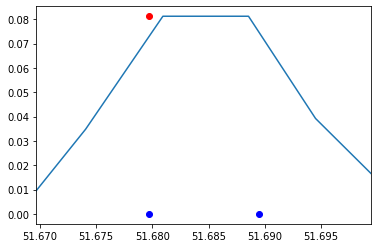

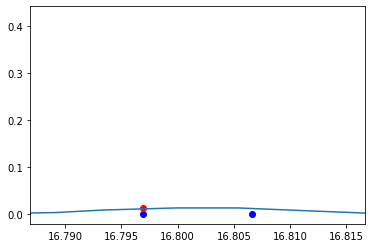

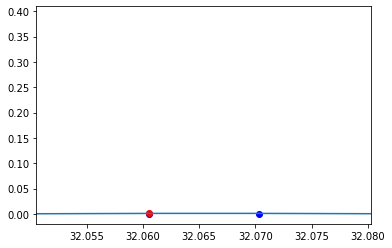

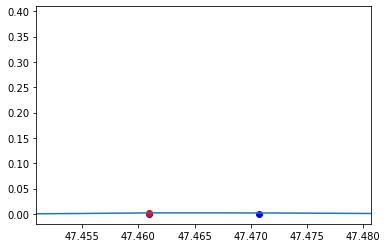

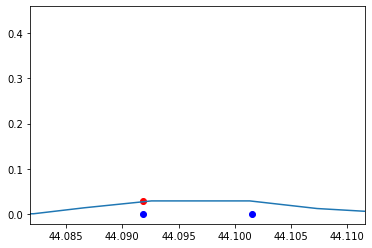

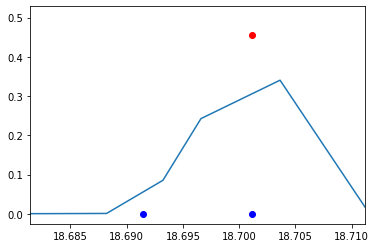

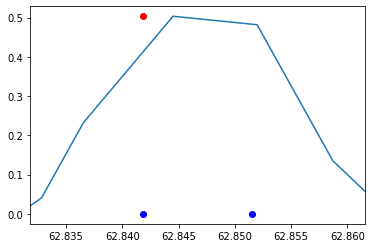

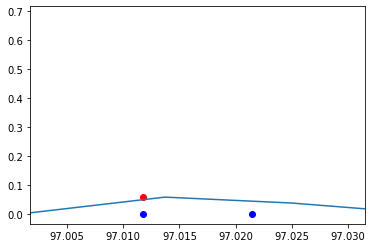

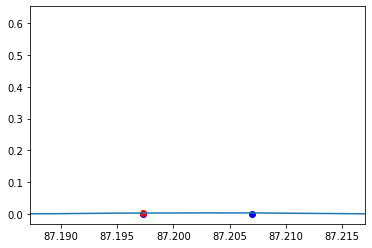

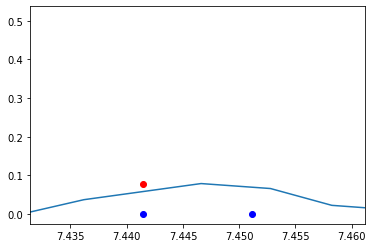

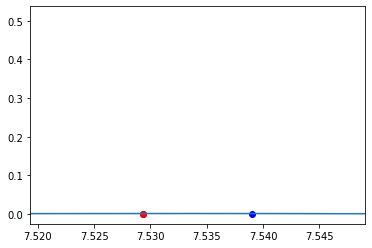

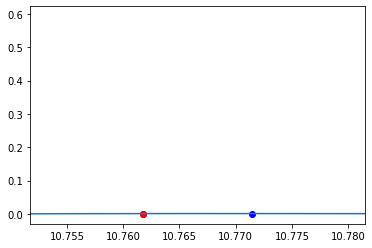

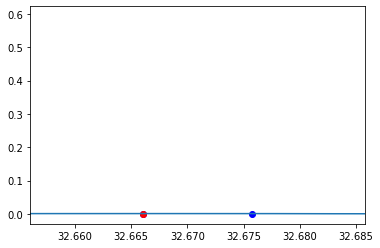

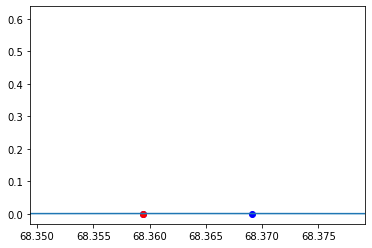

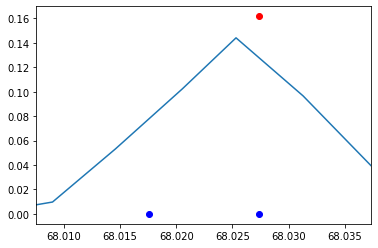

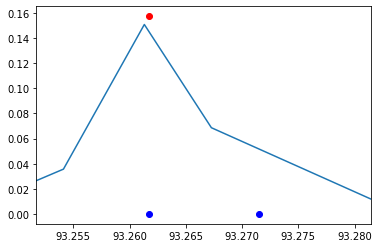

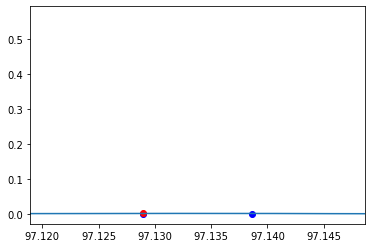

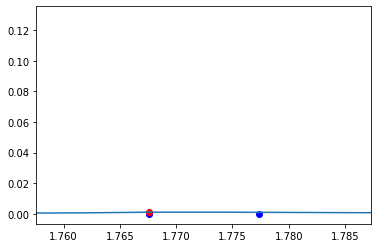

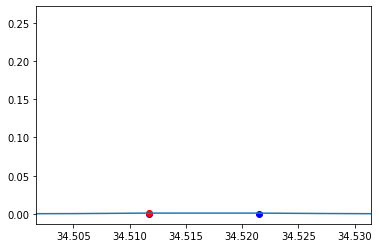

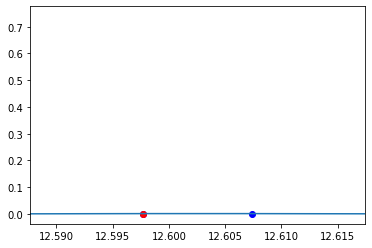

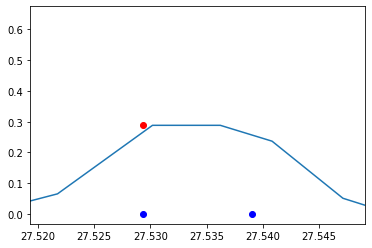

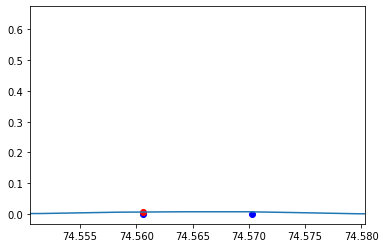

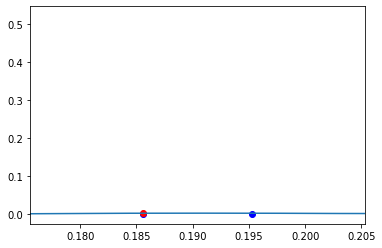

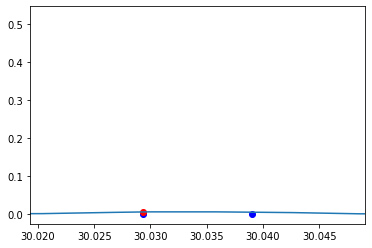

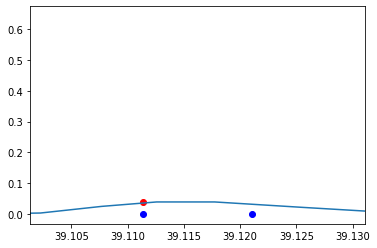

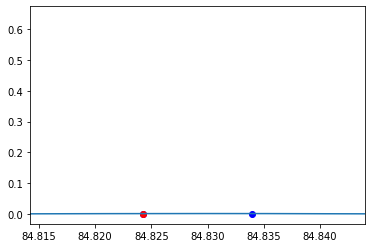

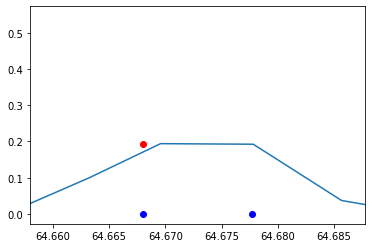

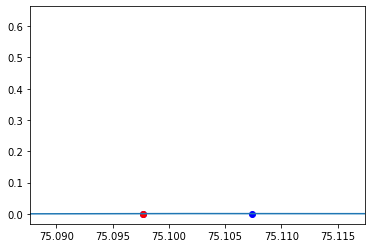

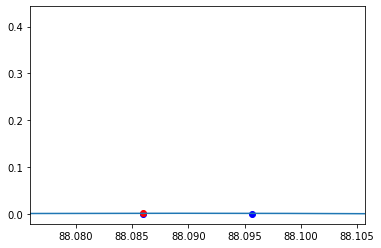

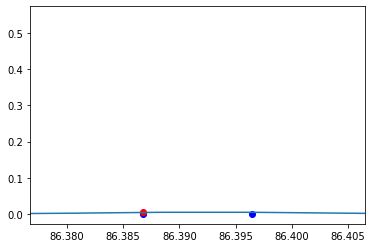

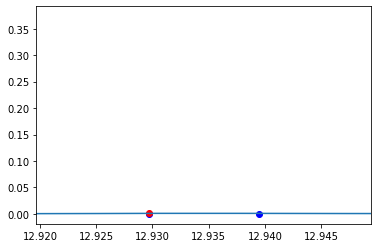

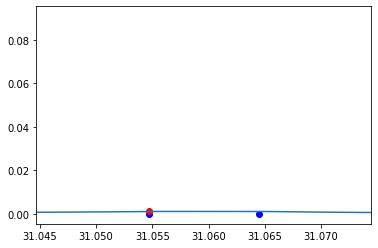

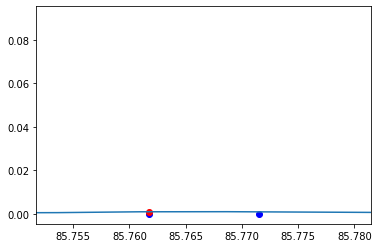

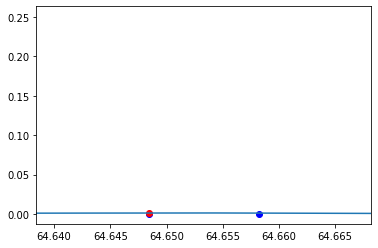

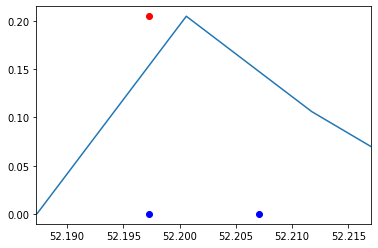

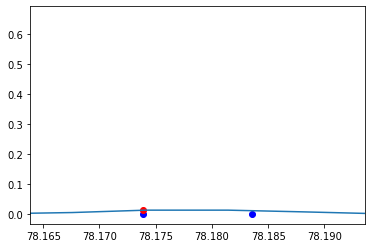

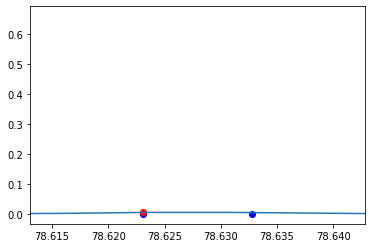

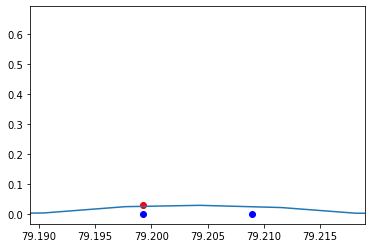

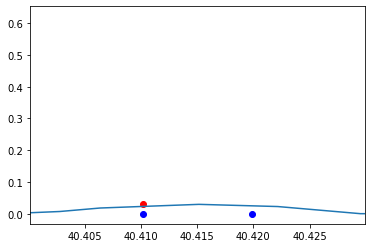

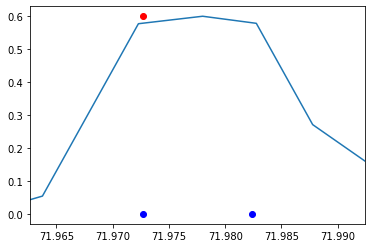

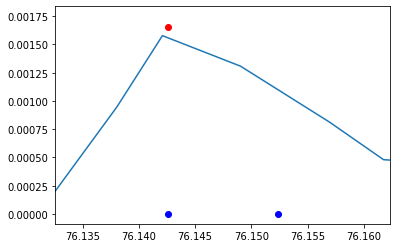

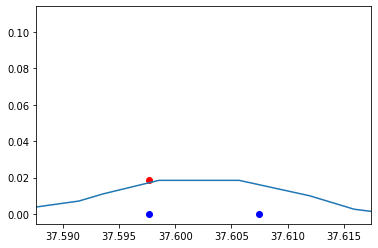

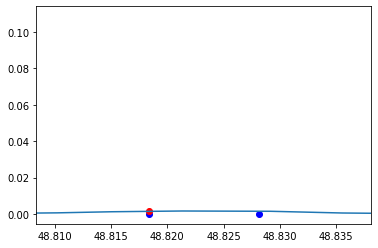

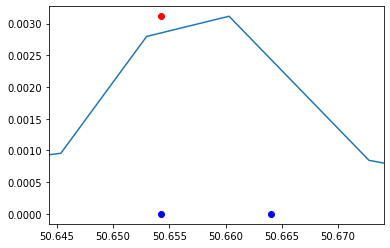

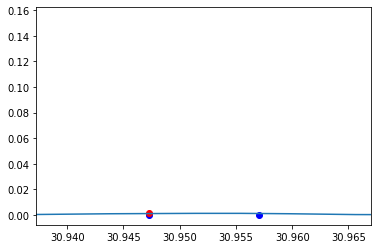

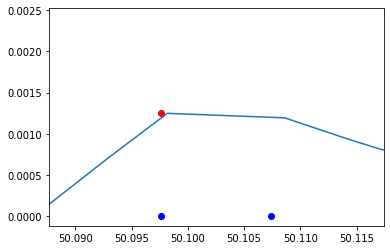

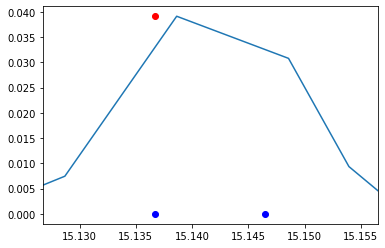

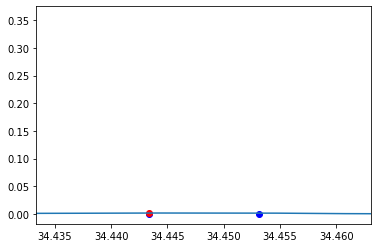

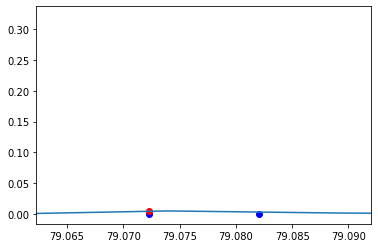

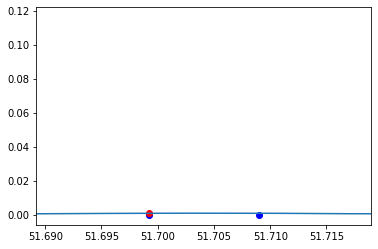

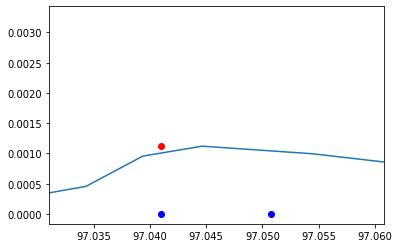

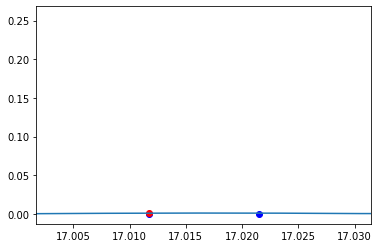

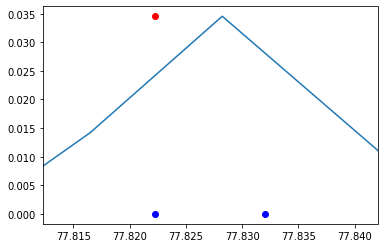

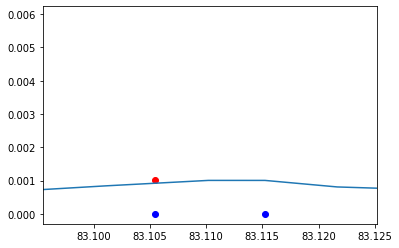

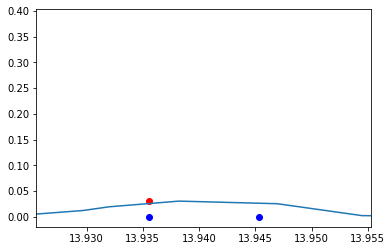

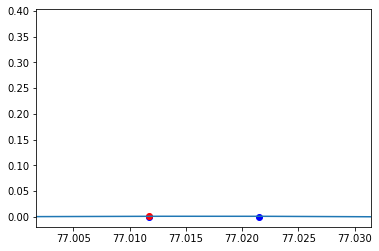

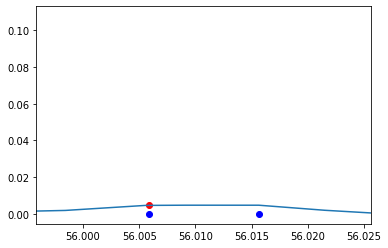

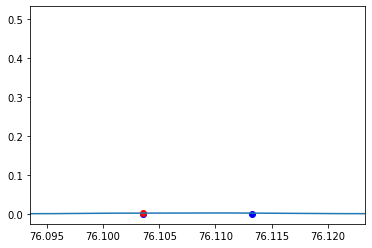

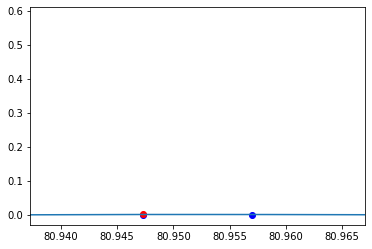

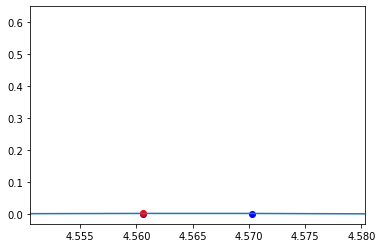

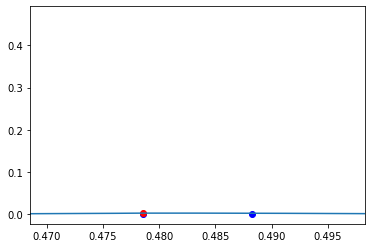

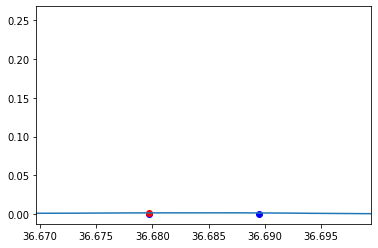

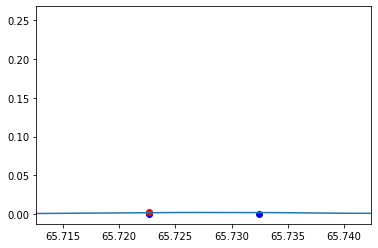

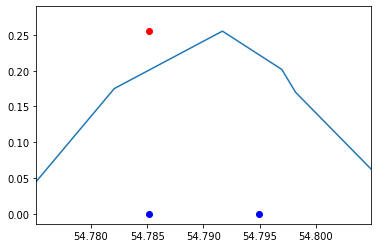

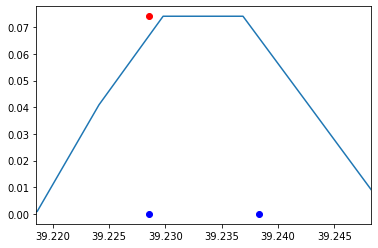

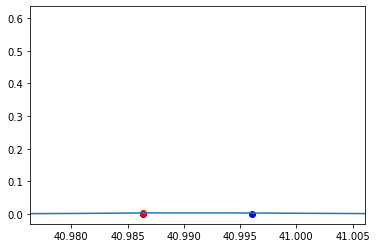

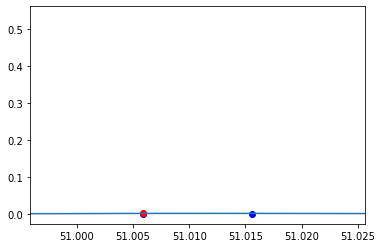

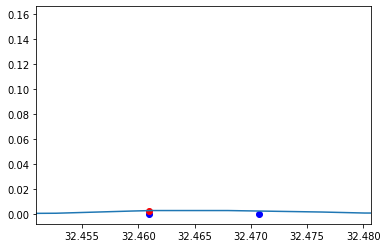

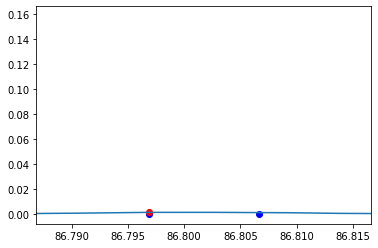

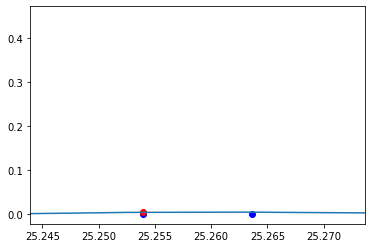

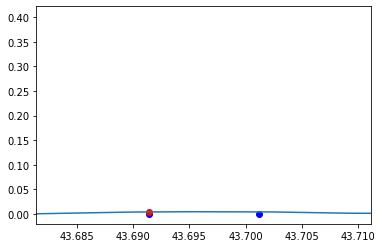

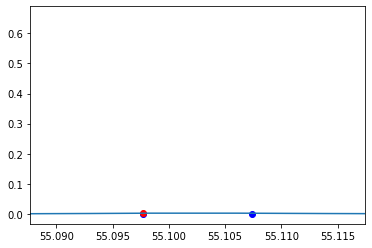

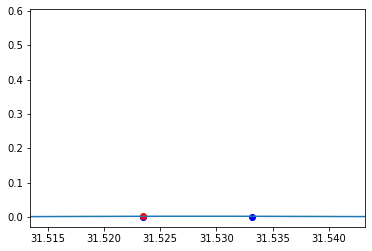

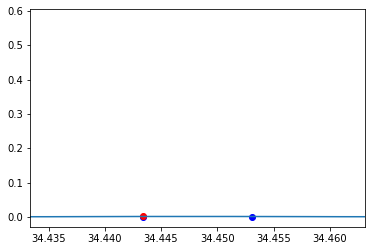

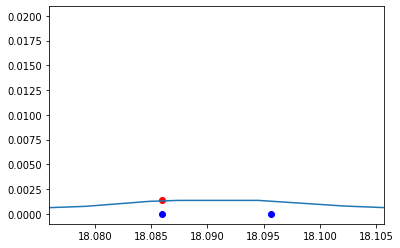

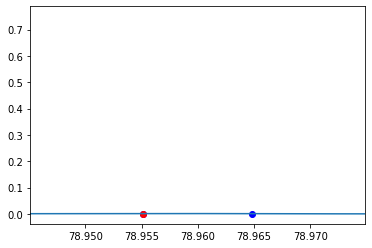

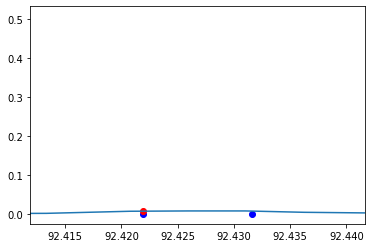

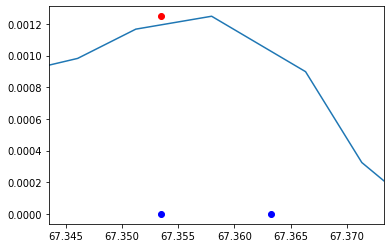

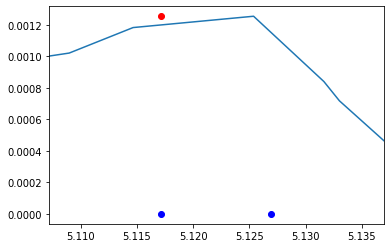

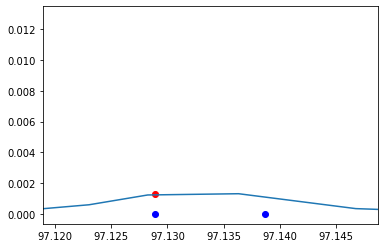

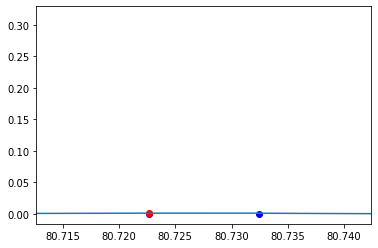

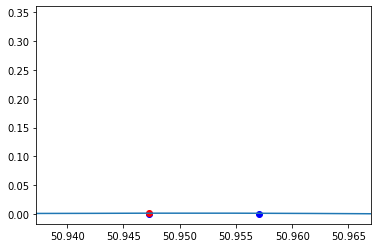

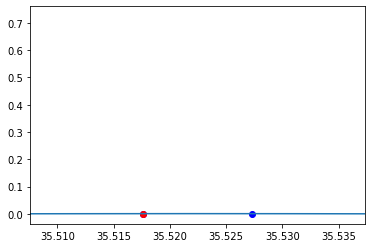

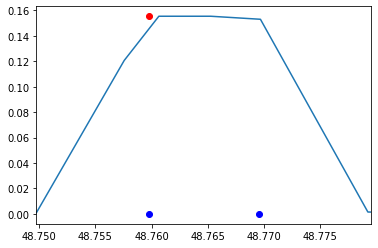

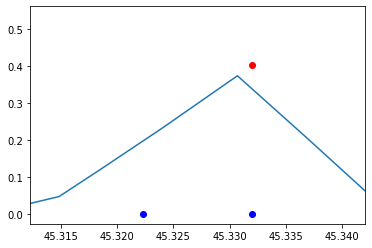

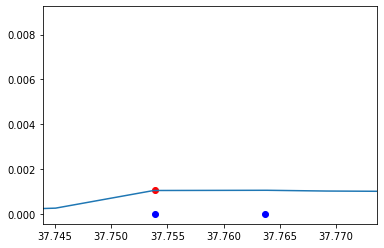

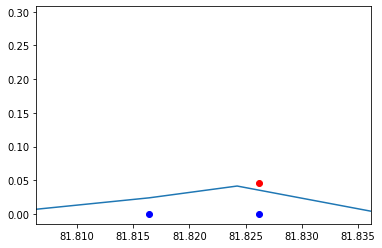

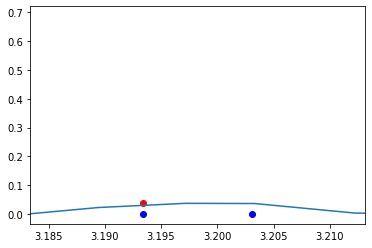

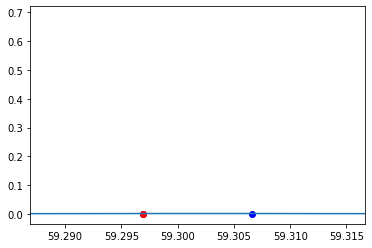

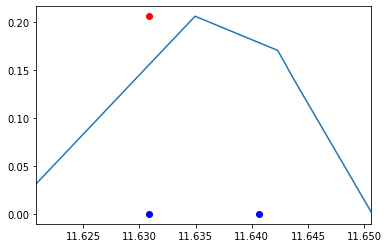

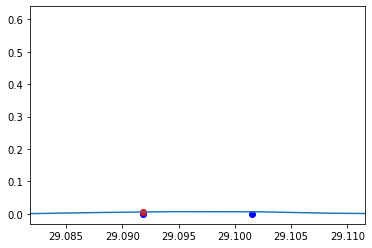

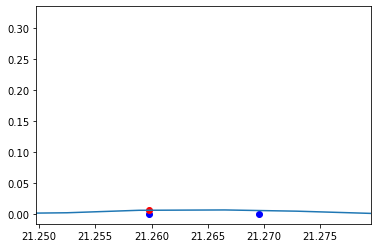

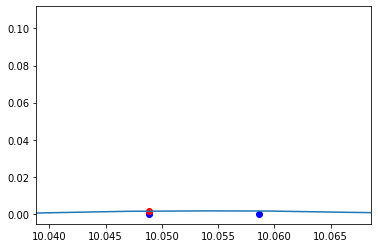

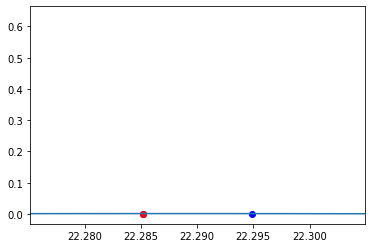

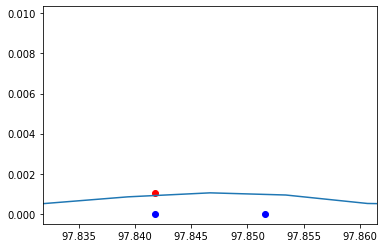

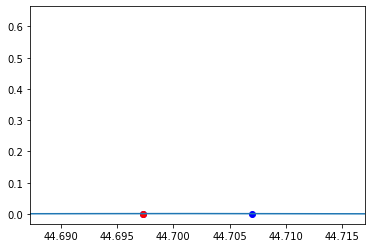

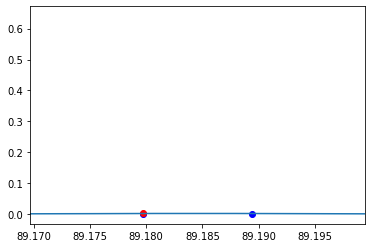

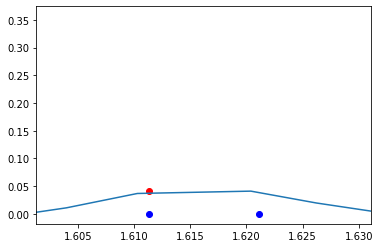

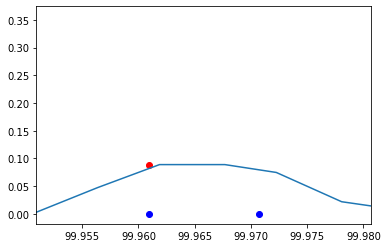

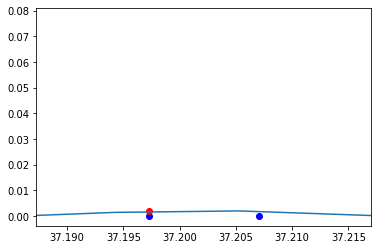

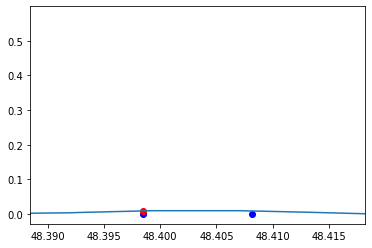

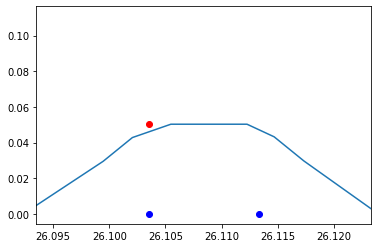

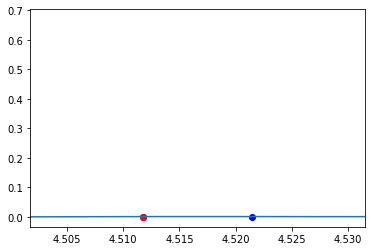

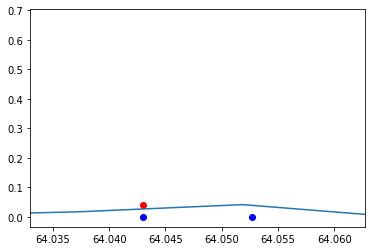

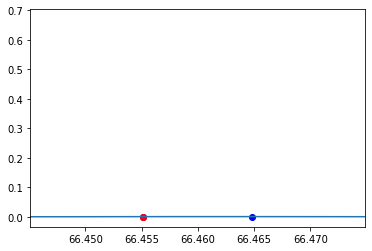

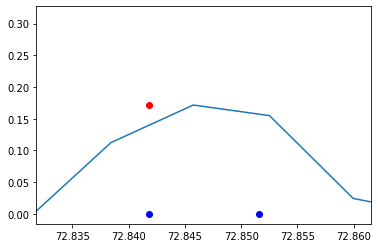

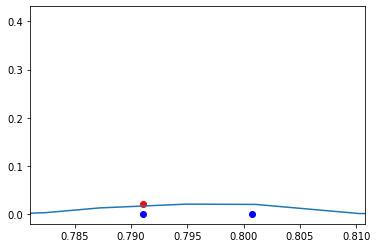

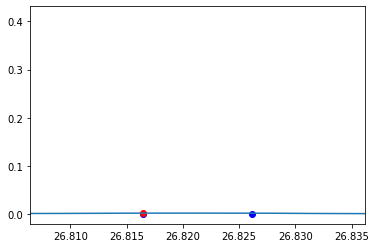

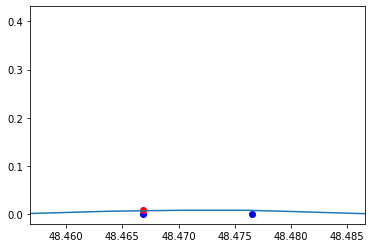

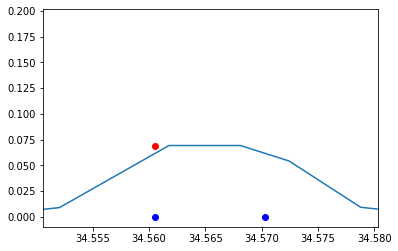

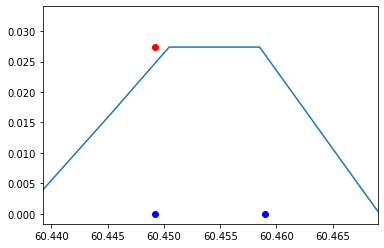

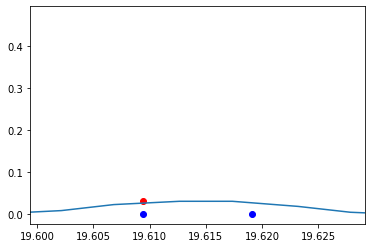

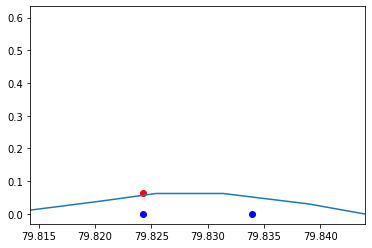

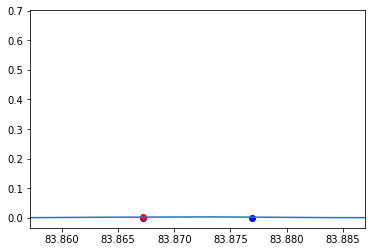

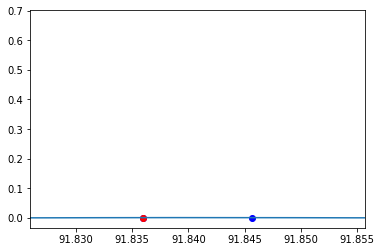

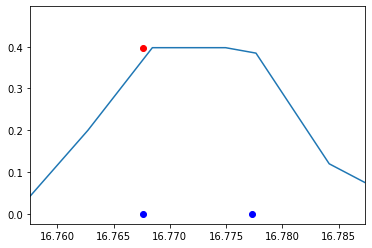

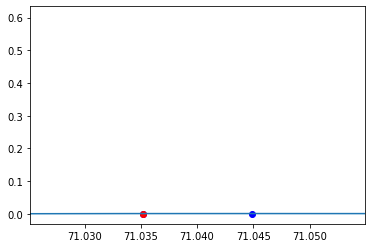

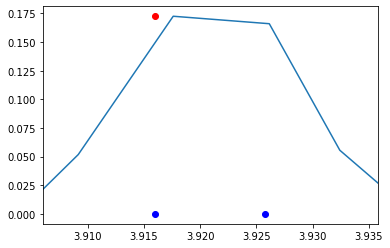

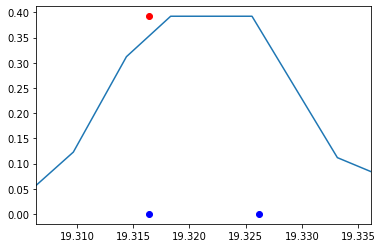

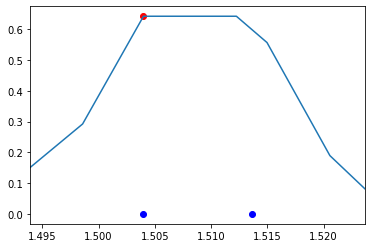

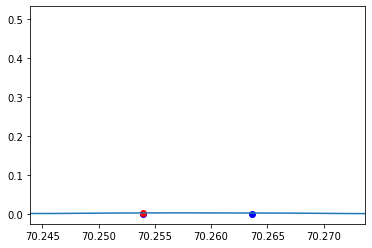

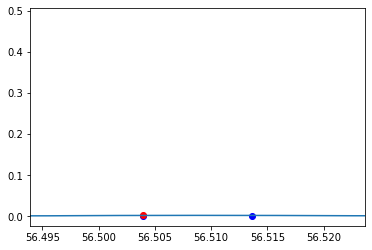

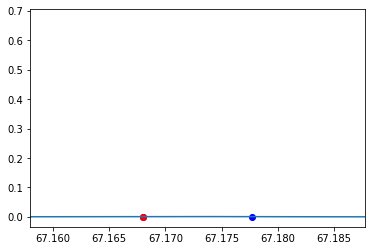

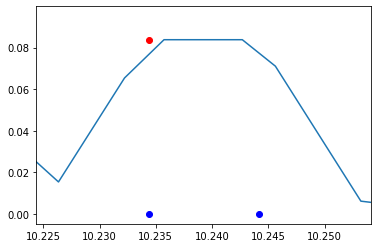

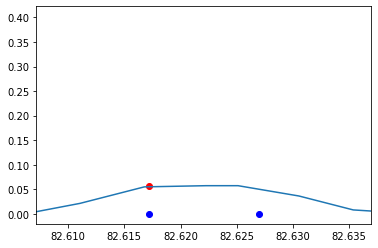

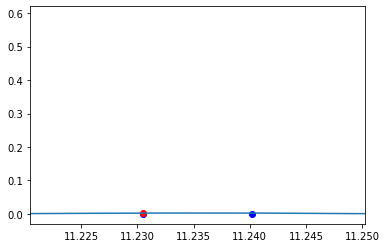

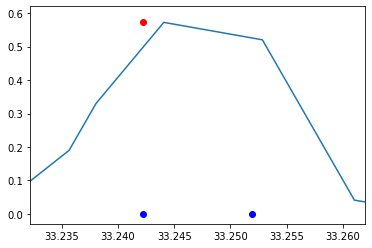

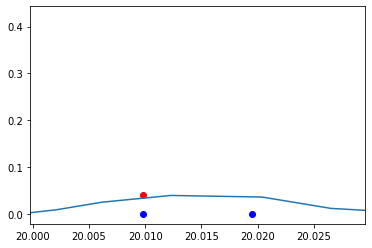

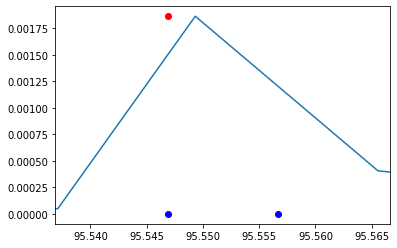

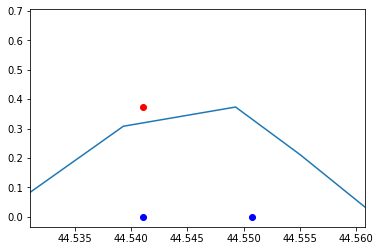

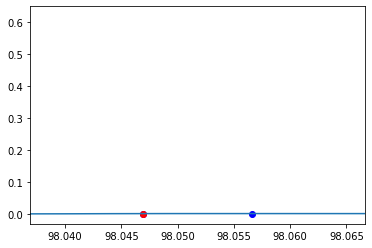

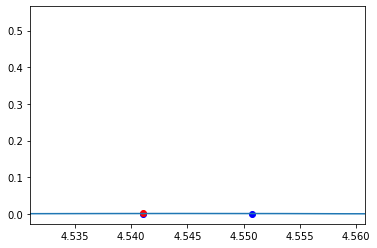

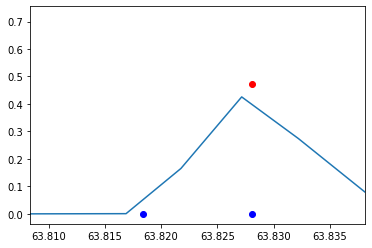

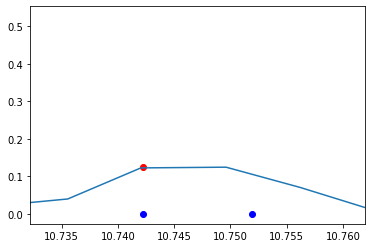

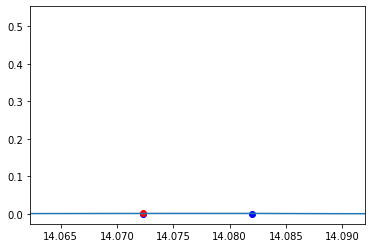

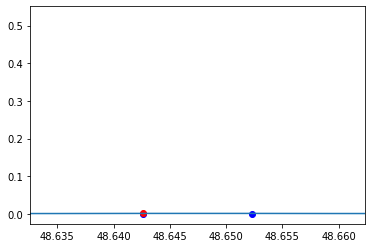

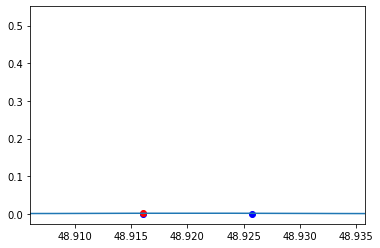

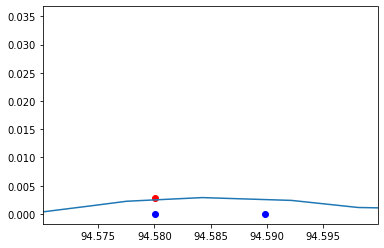

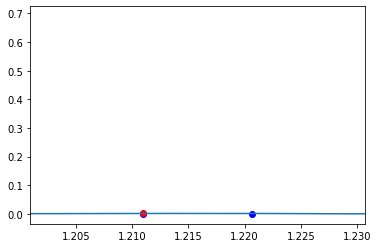

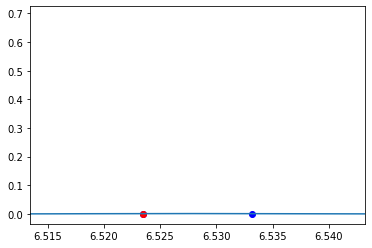

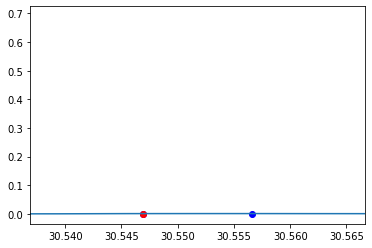

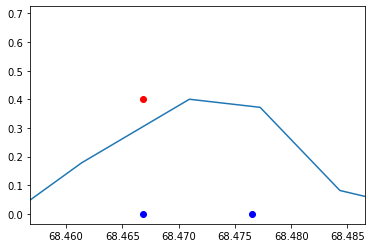

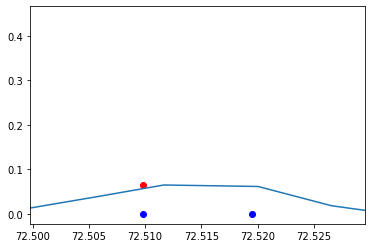

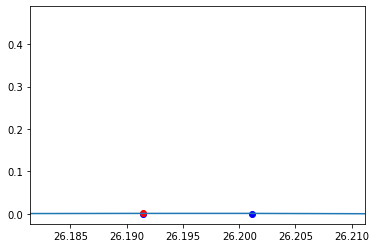

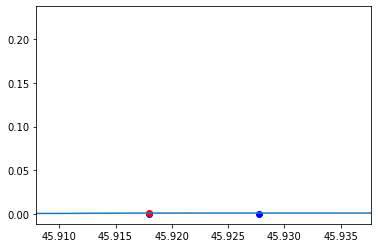

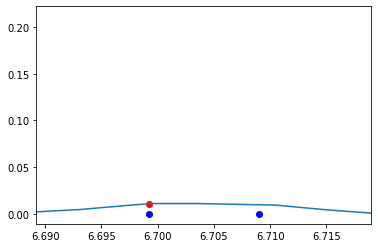

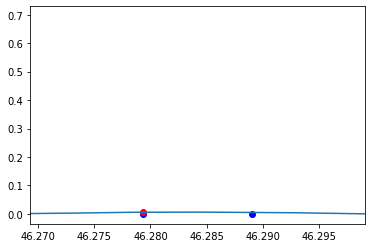

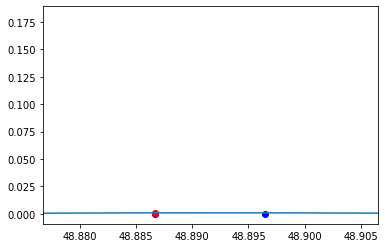

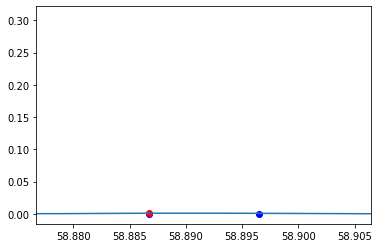

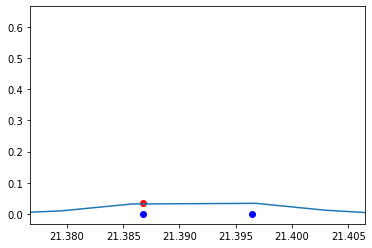

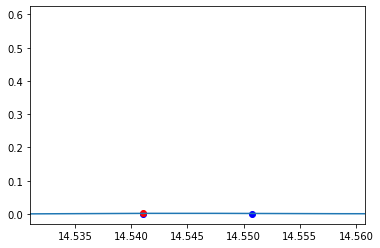

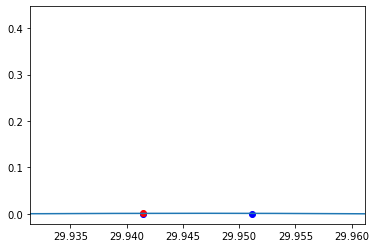

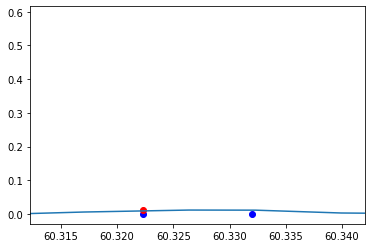

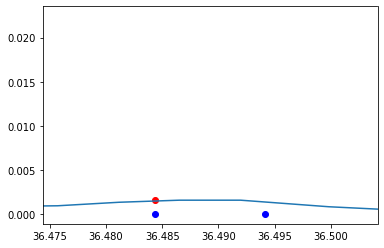

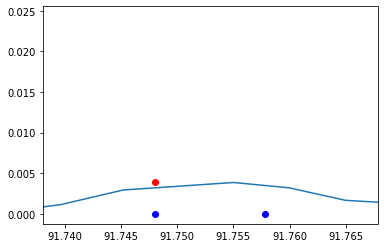

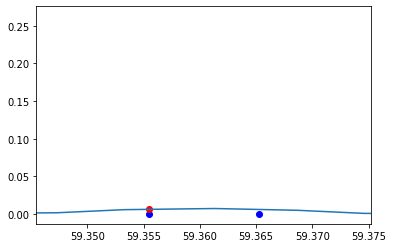

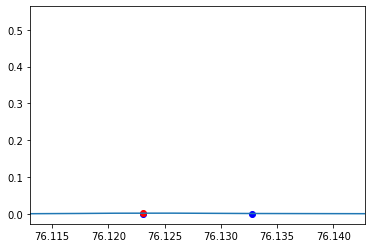

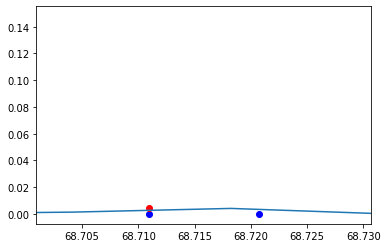

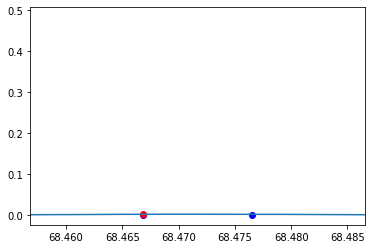

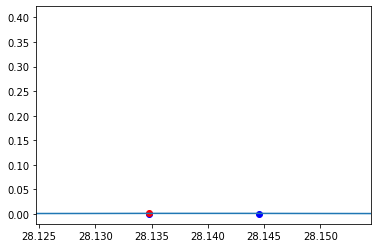

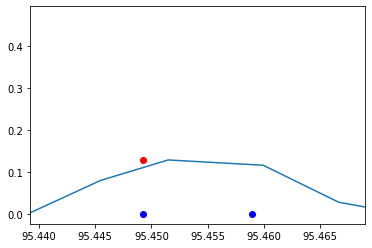

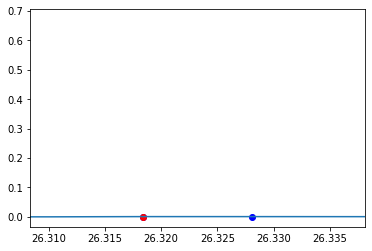

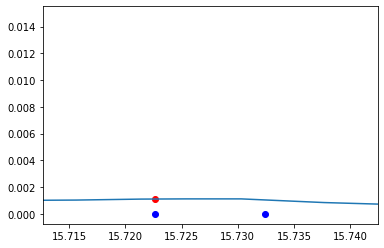

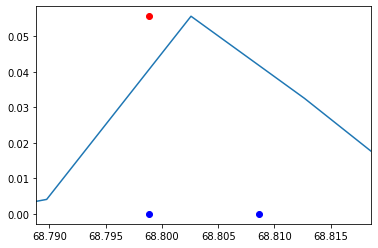

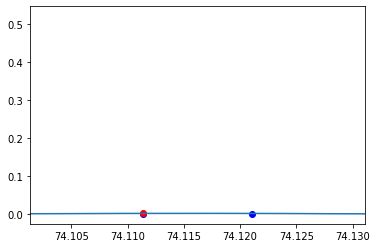

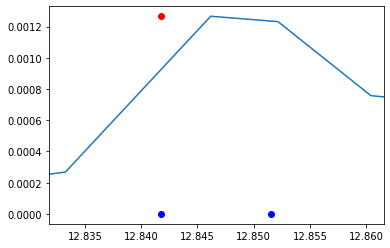

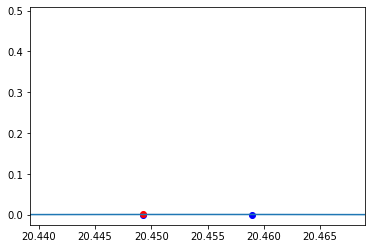

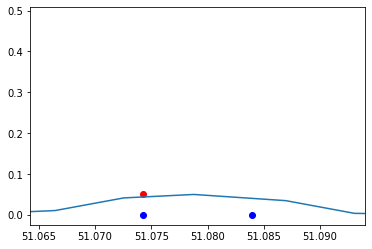

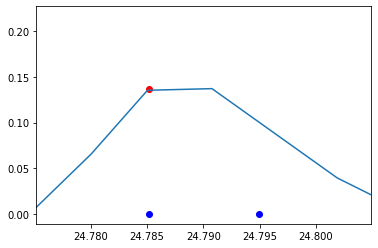

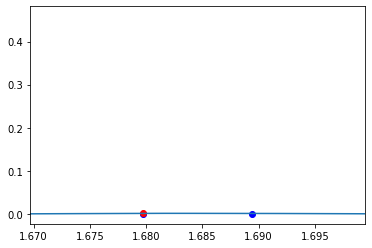

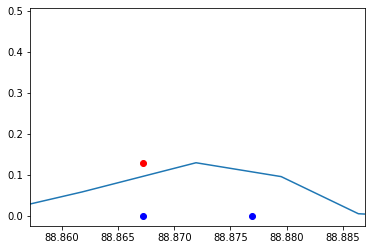

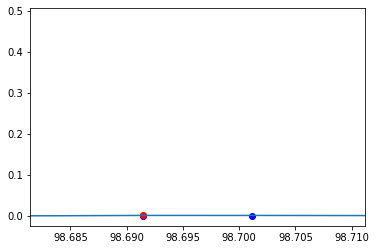

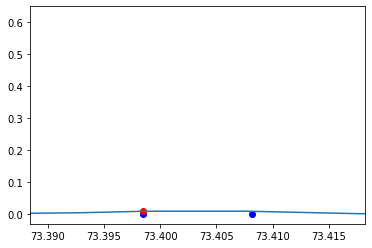

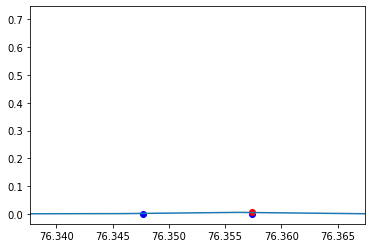

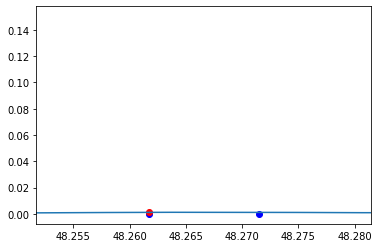

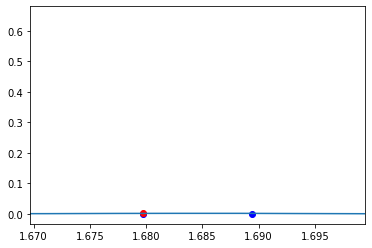

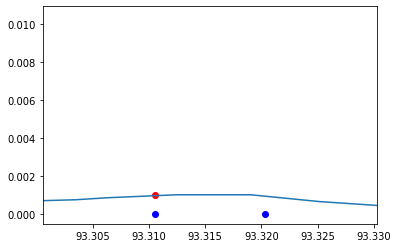

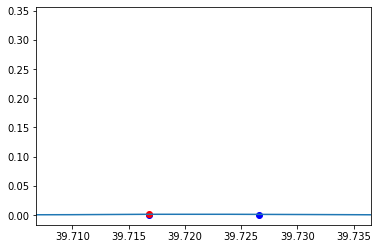

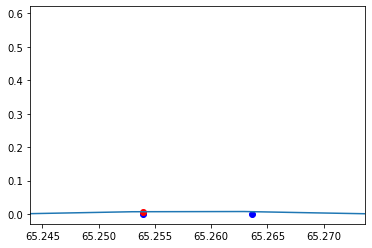

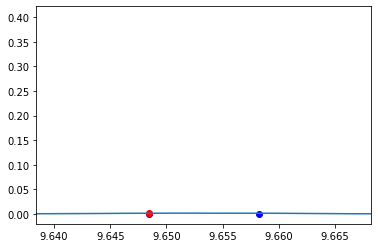

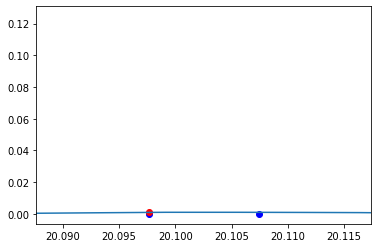

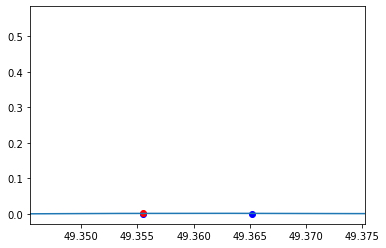

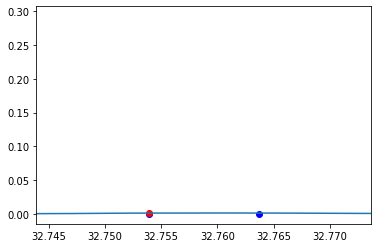

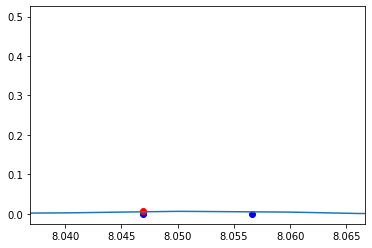

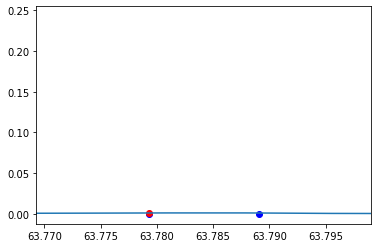

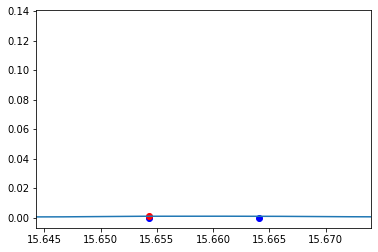

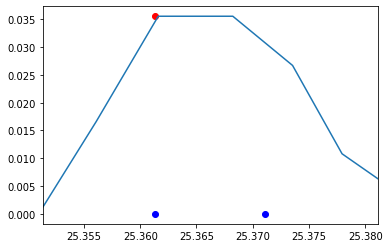

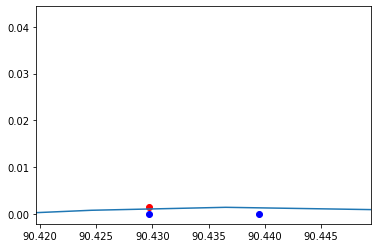

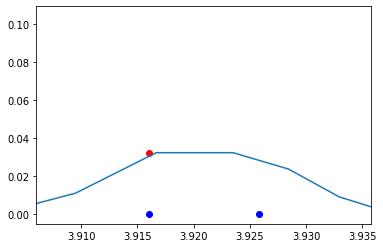

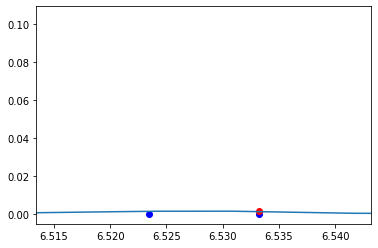

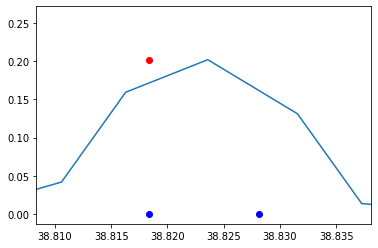

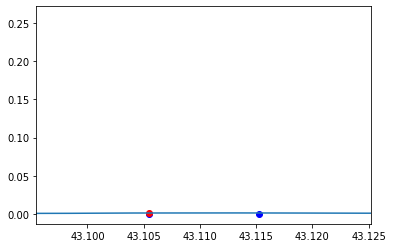

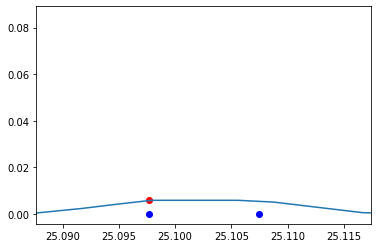

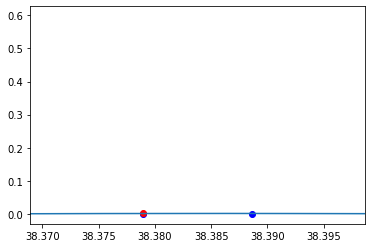

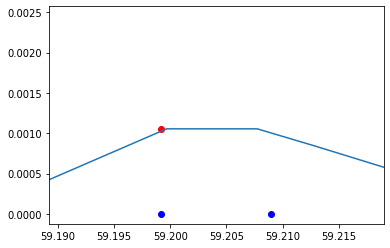

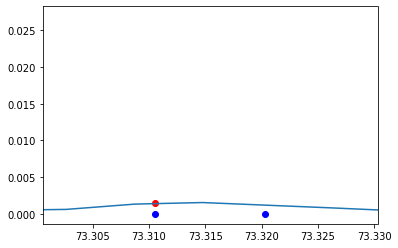

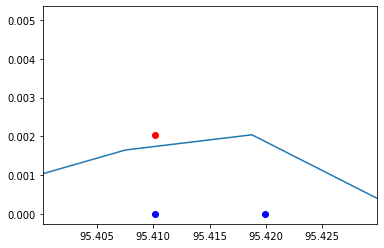

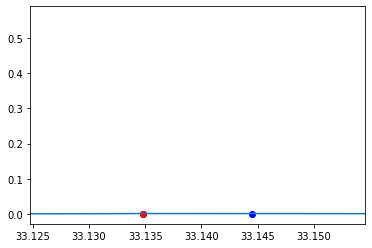

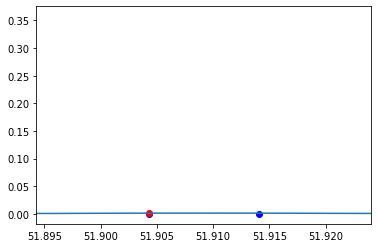

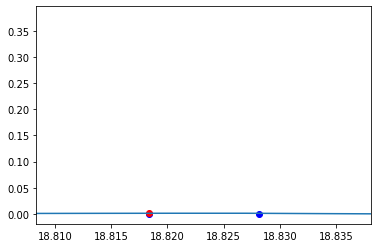

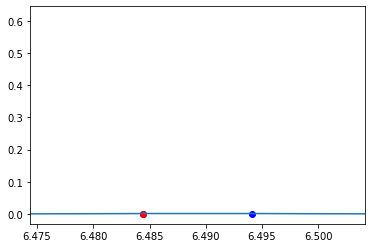

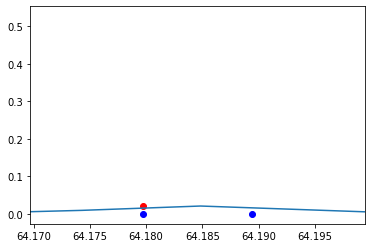

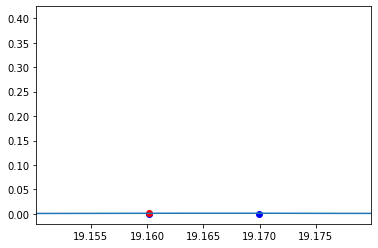

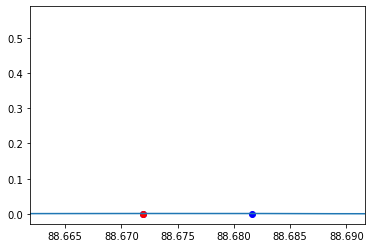

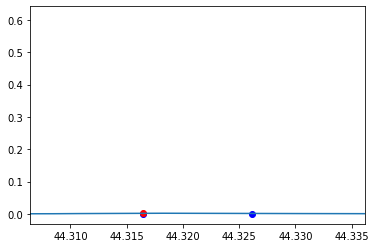

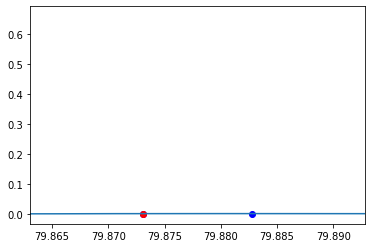

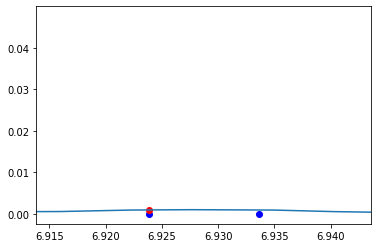

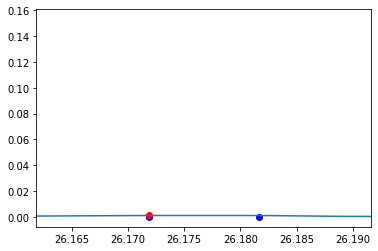

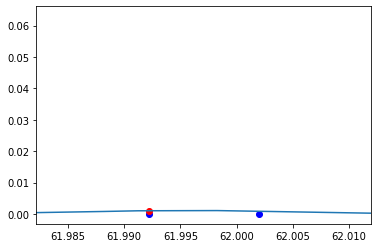

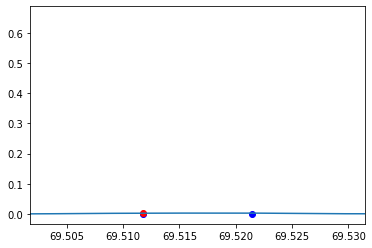

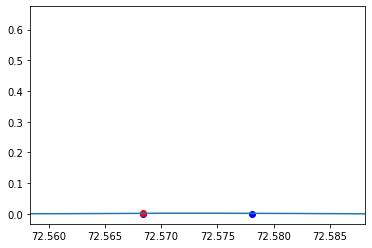

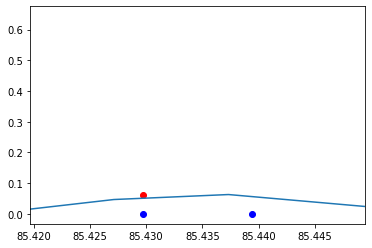

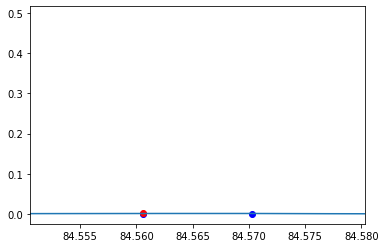

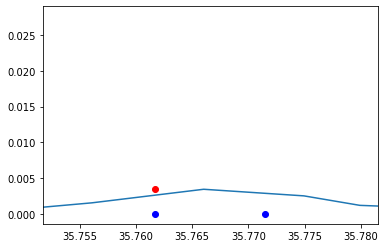

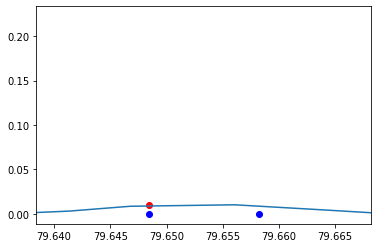

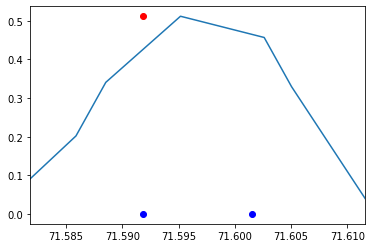

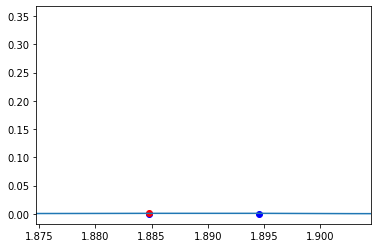

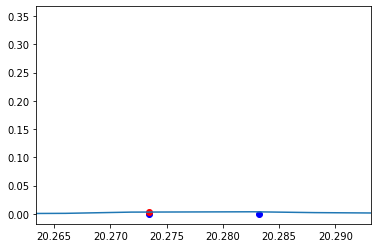

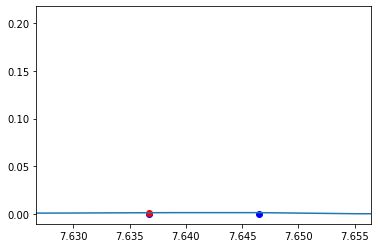

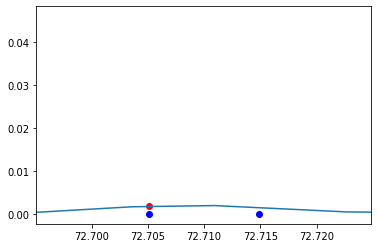

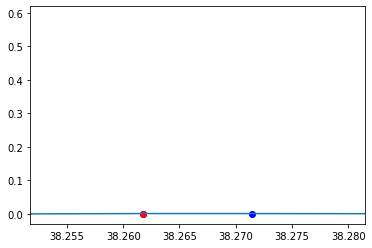

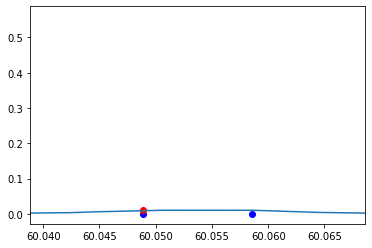

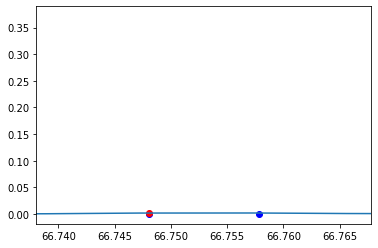

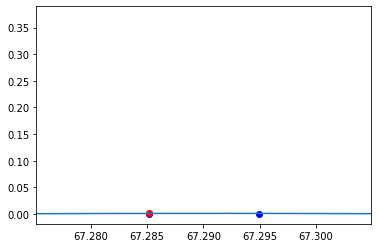

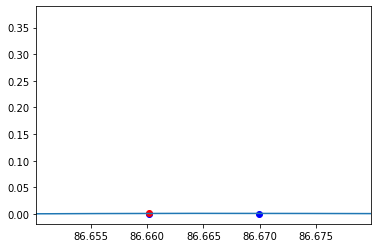

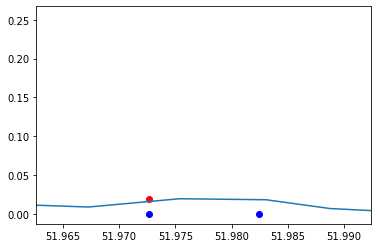

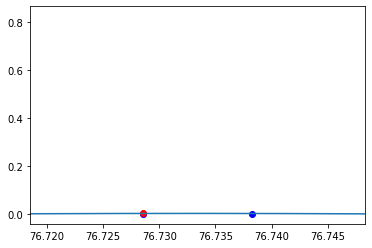

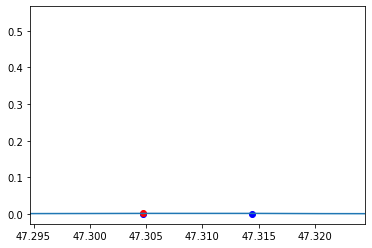

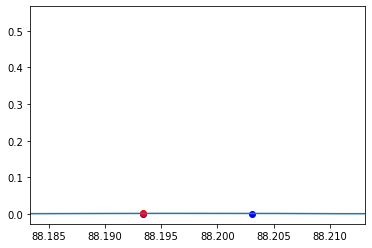

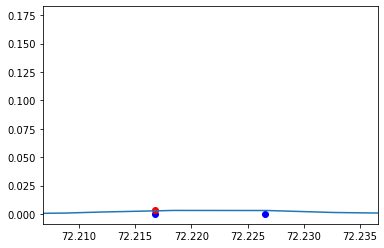

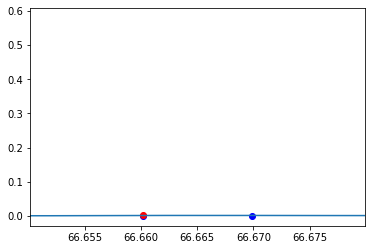

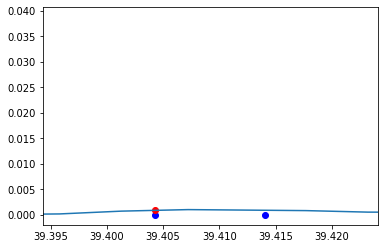

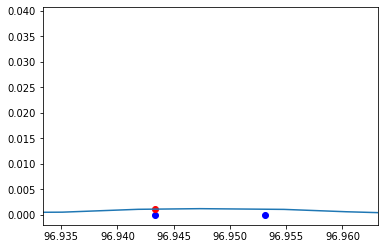

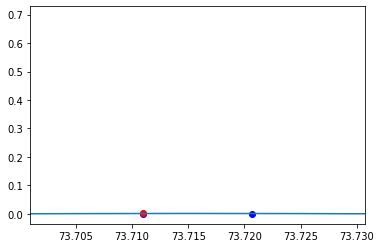

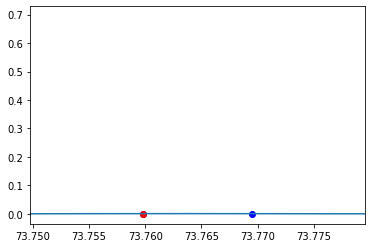

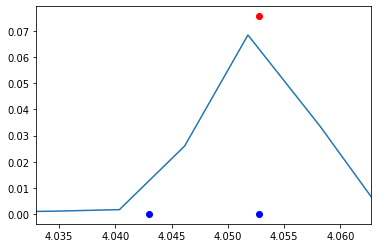

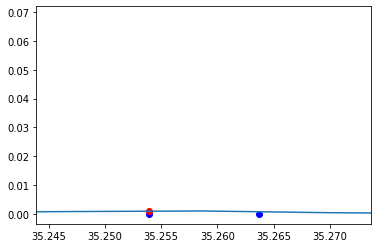

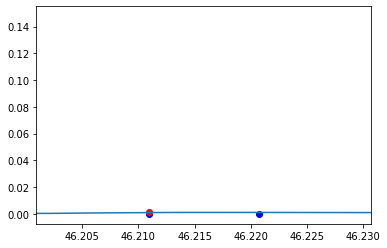

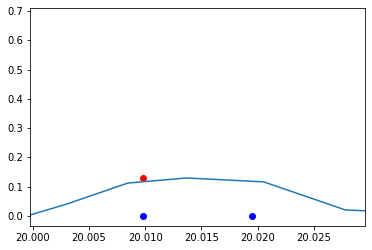

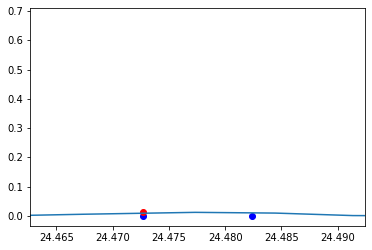

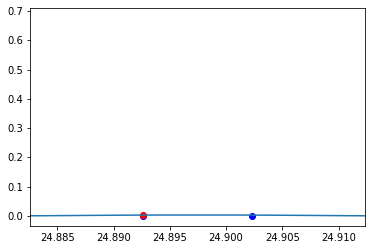

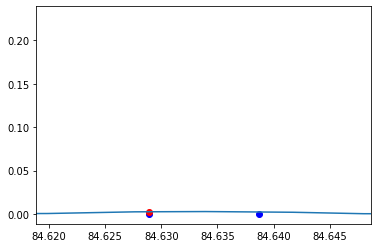

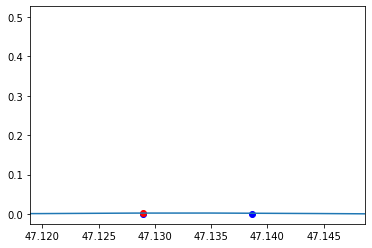

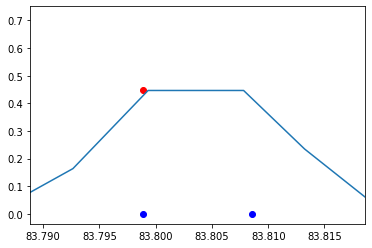

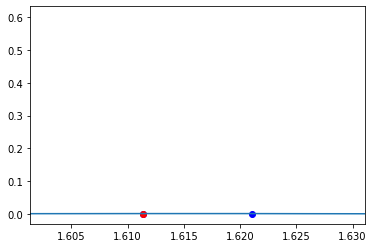

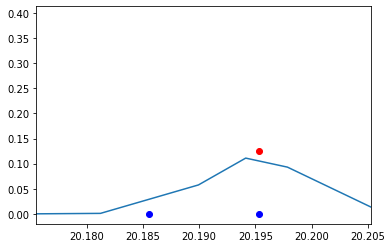

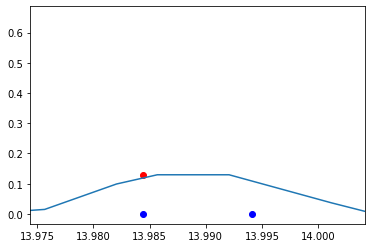

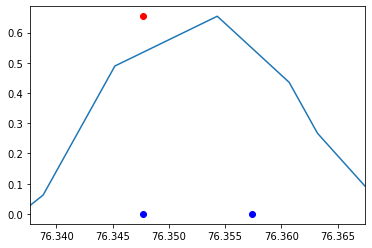

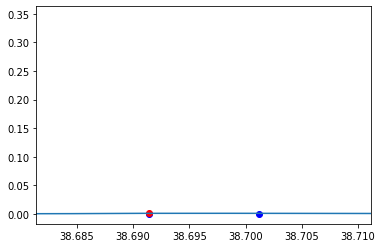

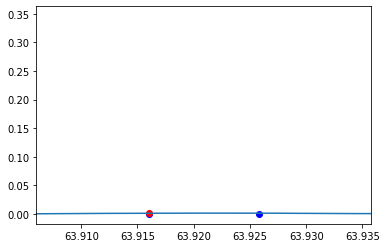

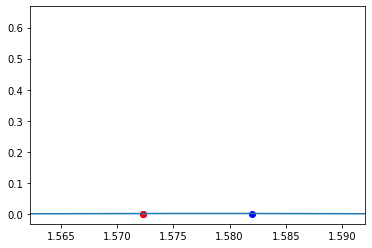

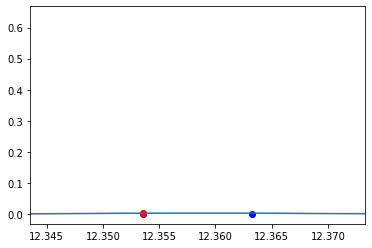

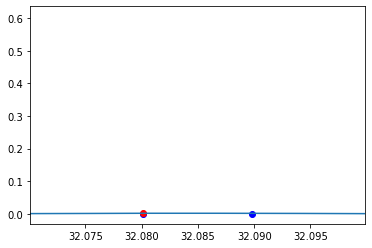

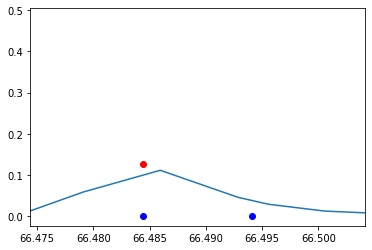

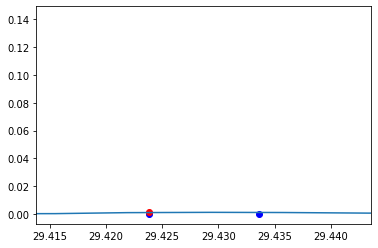

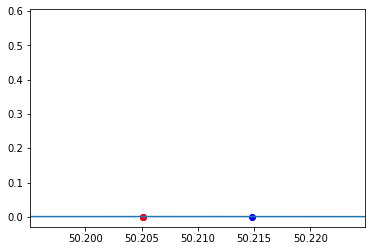

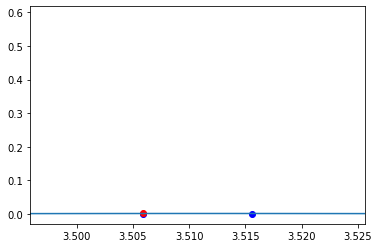

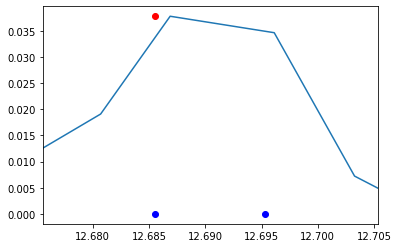

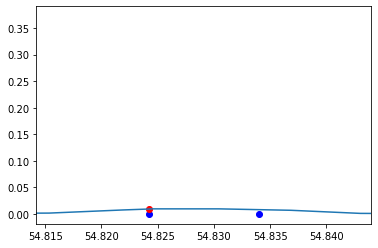

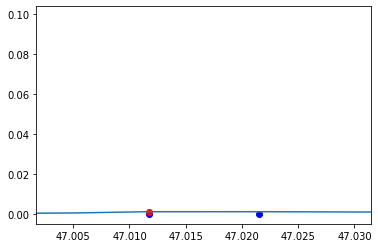

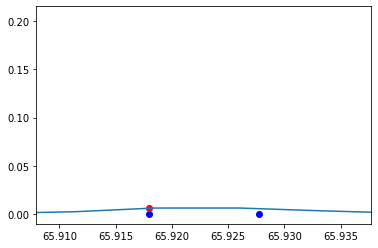

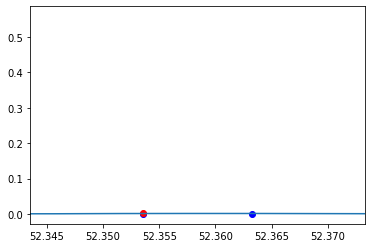

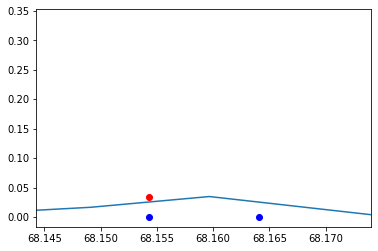

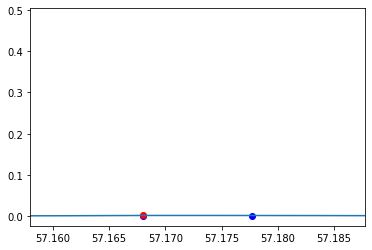

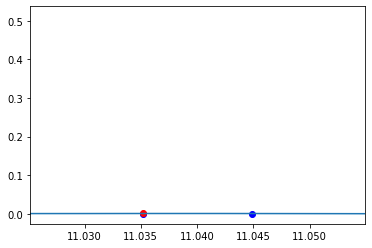

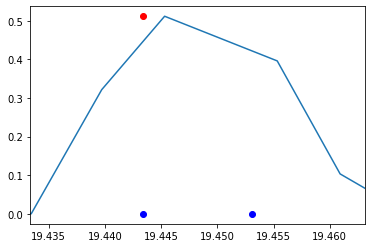

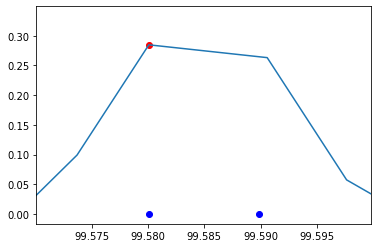

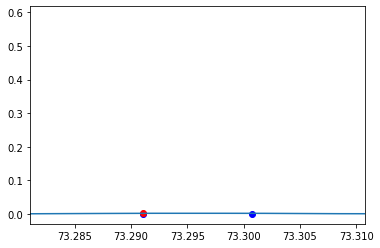

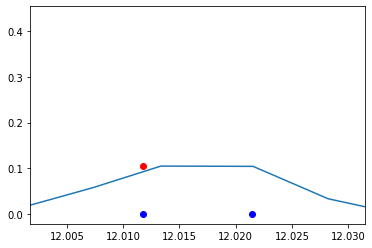

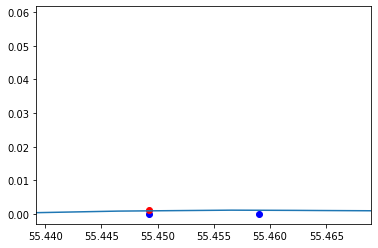

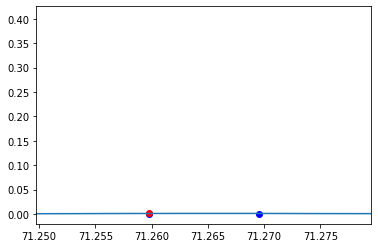

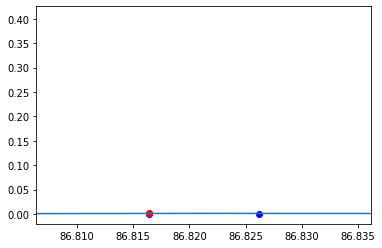

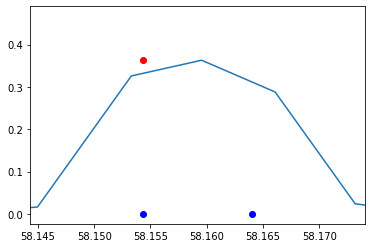

KeyboardInterrupt: 

In [ ]:
    raw_path = 'los.00' + '{0:03}'.format(i[0]) +'.raw'
    den_path =  'los.00' + '{0:03}'.format(i[0]) +'.den'
    distance, pec_vel, temp, HI_density = unPackRawFile(raw_path)
    #changing the distance from chimp to cmeters
    distance1,neutral_fraction1,gas_density1,temperature1 = unPackDenFile(den_path)
    gas_density =sp.interpolate.interp1d(distance1,gas_density1, fill_value="extrapolate")(distance)
    neutral_fraction = sp.interpolate.interp1d(distance1,neutral_fraction1, fill_value="extrapolate")(distance)
    plt.plot(distance,neutral_fraction)
    plt.scatter(i[2],0,c = "blue")
    plt.scatter(i[3],0,c = "blue")
    plt.scatter(i[1],i[5],c="red")
    plt.xlim(i[2]-0.01,i[3]+0.01)

    plt.show()